# Final Project Notebook

DS 5001 Exploratory Text Analytics | Spring 2024

# Metadata

- Full Name: Gwen Powers
- Userid: gp8cf
- GitHub Repo URL: https://github.com/gwenpowers1/ETA_finalproject
- UVA Box URL: https://virginia.box.com/s/shpyl5sie1cefby7cfg0qp84gvo5p2ty

# Overview

The goal of the final project is for you to create a **digital analytical edition** of a corpus using the tools, practices, and perspectives you’ve learning in this course. You will select a corpus that has already been digitized and transcribed, parse that into an F-compliant set of tables, and then generate and visualize the results of a series of fitted models. You will also draw some tentative conclusions regarding the linguistic, cultural, psychological, or historical features represented by your corpus. The point of the exercise is to have you work with a corpus through the entire pipeline from ingestion to interpretation. 

Specifically, you will acquire a collection of long-form texts and perform the following operations:

- **Convert** the collection from their source formats (F0) into a set of tables that conform to the Standard Text Analytic Data Model (F2).
- **Annotate** these tables with statistical and linguistic features using NLP libraries such as NLTK (F3).
- **Produce** a vector representation of the corpus to generate TFIDF values to add to the TOKEN (aka CORPUS) and VOCAB tables (F4).
- **Model** the annotated and vectorized model with tables and features derived from the application of unsupervised methods, including PCA, LDA, and word2vec (F5).
- **Explore** your results using statistical and visual methods.
- **Present** conclusions about patterns observed in the corpus by means of these operations.

When you are finished, you will make the results of your work available in GitHub (for code) and UVA Box (for data). You will submit to Gradescope (via Canvas) a PDF version of a Jupyter notebook that contains the information listed below.

# Some Details

- Please fill out your answers in each task below by editing the markdown cell. 
- Replace text that asks you to insert something with the thing, i.e. replace `(INSERT IMAGE HERE)` with an image element, e.g. `![](image.png)`.
- For URLs, just paste the raw URL directly into the text area. Don't worry about providing link labels using `[label](link)`.
- Please do not alter the structure of the document or cell, i.e. the bulleted lists. 
- You may add explanatory paragraphs below the bulleted lists.
- Please name your tables as they are named in each task below.
- Tasks are indicated by headers with point values in parentheses.

# Raw Data

## Source Description (1)

Provide a brief description of your source material, including its provenance and content. Tell us where you found it and what kind of content it contains.

##### I found the entire set of original Nancy Drew Myster novels on an archive website that had the works split by book in a variety of different formats. I chose txt files for this project, and I found them to be pretty well organized, requiring only minor tweaking and cleaning of systematic typos. I also took the liberty of adding the ghost author and publication dates from what I could find online in order to provide more features for my analysis.

## Source Features (1)

Add values for the following items. (Do this for all following bulleted lists.)

- Source URL: https://archive.org/details/nancydrew/001%20The%20Secret%20of%20the%20Old%20Clock/page/n133/mode/2up
- UVA Box URL: https://virginia.box.com/s/shpyl5sie1cefby7cfg0qp84gvo5p2ty
- Number of raw documents: 12
- Total size of raw documents (e.g. in MB): 2.429 MB
- File format(s), e.g. XML, plaintext, etc.: txt files

## Source Document Structure (1)

Provide a brief description of the internal structure of each document. That, describe the typical elements found in document and their relation to each other. For example, a corpus of letters might be described as having a date, an addressee, a salutation, a set of content paragraphs, and closing. If they are various structures, state that.

##### Each document is a Nancy Drew Myster novel that has a title, author, ghost author, a set of chapters, and a publication date. 

# Parsed and Annotated Data

Parse the raw data into the three core tables of your addition: the `LIB`, `CORPUS`, and `VOCAB` tables.

These tables will be stored as CSV files with header rows.

You may consider using `|` as a delimitter.

Provide the following information for each.

## LIB (2)

The source documents the corpus comprises. These may be books, plays, newspaper articles, abstracts, blog posts, etc. 

Note that these are *not* documents in the sense used to describe a bag-of-words representation of a text, e.g. chapter.

- UVA Box URL: https://virginia.box.com/s/shpyl5sie1cefby7cfg0qp84gvo5p2ty
- GitHub URL for notebook used to create:
- Delimitter: ' '
- Number of observations: 12
- List of features, including at least three that may be used for model summarization (e.g. date, author, etc.): book_id, source_file_path, title, author, ghost_author, publication_date, (added book_len and n_chaps after making CORPUS)
- Average length of each document in characters: 42974.5

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk

In [2]:
source_files = f'nancy_drew_files'

In [3]:
chapter_pattern = rf"^CHAPTER\s+[IVXLCM]+\.\s*$"

In [4]:
source_file_list = sorted(glob(f"{source_files}/*.*"))

In [5]:
source_file_list

['nancy_drew_files/001 The Secret of the Old Clock_djvu.txt',
 'nancy_drew_files/002 The Hidden Staircase_djvu.txt',
 'nancy_drew_files/003 The Bungalow Mystery_djvu.txt',
 'nancy_drew_files/004 The Mystery at Lilac Inn_djvu.txt',
 'nancy_drew_files/005 The Secret of Shadow Ranch_djvu.txt',
 'nancy_drew_files/006 The Secret of Red Gate Farm_djvu.txt',
 'nancy_drew_files/007 The Clue in the Diary_djvu.txt',
 "nancy_drew_files/008 Nancy's Mysterious Letter_djvu.txt",
 'nancy_drew_files/009 The Sign of the Twisted Candles_djvu.txt',
 'nancy_drew_files/010 Password to Larkspur Lane_djvu.txt',
 'nancy_drew_files/011 The Clue of the Broken Locket_djvu.txt',
 'nancy_drew_files/012 The Message in the Hollow Oak_djvu.txt']

In [6]:
book_data = []
for idx, source_file_path in enumerate(source_file_list):
    book_id = idx + 1
    # Open and read the file
    with open(source_file_path, 'r', encoding='utf-8') as file:
        text = file.read()
        # Extract title, author, and publication year
        title_search = re.search(r'(.*)\nBy', text)
        author_search = re.search(r'By (.*) \((.*)\)', text)
        publication_search = re.search(r'PUBLISHED (\d{4})', text)
        if title_search and author_search and publication_search:
            book_title = title_search.group(1).strip()
            author = author_search.group(1).strip()
            ghost_author = author_search.group(2).strip()
            publication_date = publication_search.group(1).strip()
        else:
            book_title = "Unknown"
            author = "Unknown"
            ghost_author = "Unknown"
            publication_date = "Unknown"
    # Append data tuple to book_data list
    book_data.append((book_id, source_file_path, book_title, author, ghost_author, publication_date))


In [7]:
LIB = pd.DataFrame(book_data, columns=['book_id', 'source_file_path', 'title', 'author', 'ghost_author', 'publication_date'])\
    .set_index('book_id').sort_index()

In [8]:
LIB

source_file_path  \
book_id                                                      
1        nancy_drew_files/001 The Secret of the Old Clo...   
2        nancy_drew_files/002 The Hidden Staircase_djvu...   
3        nancy_drew_files/003 The Bungalow Mystery_djvu...   
4        nancy_drew_files/004 The Mystery at Lilac Inn_...   
5        nancy_drew_files/005 The Secret of Shadow Ranc...   
6        nancy_drew_files/006 The Secret of Red Gate Fa...   
7        nancy_drew_files/007 The Clue in the Diary_djv...   
8        nancy_drew_files/008 Nancy's Mysterious Letter...   
9        nancy_drew_files/009 The Sign of the Twisted C...   
10       nancy_drew_files/010 Password to Larkspur Lane...   
11       nancy_drew_files/011 The Clue of the Broken Lo...   
12       nancy_drew_files/012 The Message in the Hollow...   

                                   title         author  ghost_author  \
book_id                                                                 
1            THE SECRET OF THE OLD CLOCK  Carolyn Keene  Mildred Wirt   
2                   THE HIDDEN STAIRCASE  Carolyn Keene  Mildred Wirt   
3                   THE BUNGALOW MYSTERY  Carolyn Keene  Mildred Wirt   
4               THE MYSTERY AT LILAC INN  Carolyn Keene  Mildred Wirt   
5             THE SECRET OF SHADOW RANCH  Carolyn Keene  Mildred Wirt   
6            THE SECRET OF RED GATE FARM  Carolyn Keene  Mildred Wirt   
7                  THE CLUE IN THE DIARY  Carolyn Keene  Mildred Wirt   
8              NANCY'S MYSTERIOUS LETTER  Carolyn Keene  Walter Karig   
9        THE SIGN OF THE TWISTED CANDLES  Carolyn Keene  Walter Karig   
10             PASSWORD TO LARKSPUR LANE  Carolyn Keene  Walter Karig   
11         THE CLUE OF THE BROKEN LOCKET  Carolyn Keene  Mildred Wirt   
12         THE MESSAGE IN THE HOLLOW OAK  Carolyn Keene  Mildred Wirt   

        publication_date  
book_id                   
1                   1930  
2                   1930  
3                   1930  
4                   1930  
5                   1931  
6                   1931  
7                   1932  
8                   1932  
9                   1933  
10                  1933  
11                  1934  
12                  1935

### note: added 2 more features to LIB after making CORPUS

## CORPUS (2)

The sequence of word tokens in the corpus, indexed by their location in the corpus and document structures.

- UVA Box URL: https://virginia.box.com/s/shpyl5sie1cefby7cfg0qp84gvo5p2ty
- GitHub URL for notebook used to create:
- Delimitter:' '
- Number of observations Between (should be >= 500,000 and <= 2,000,000 observations.): 515,694
- OHCO Structure (as delimitted column names):['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
- Columns (as delimitted column names, including `token_str`, `term_str`, `pos`, and `pos_group`):['token_str', 'term_str', 'pos', 'pos_group']

In [9]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

In [10]:
from nltk.tokenize import PunktSentenceTokenizer, WordPunctTokenizer
import string

In [11]:
def is_punctuation_or_symbol(token):
    return re.match(r'^[\W_]+$', token) is not None

def custom_tokenize_and_pos_tag(text):
    tokens = WordPunctTokenizer().tokenize(text)
    pos_tags = []
    for token in tokens:
        # Check if the token is punctuation or a special character using a regex that matches non-word characters
        if is_punctuation_or_symbol(token):
            pos_tags.append((token, 'SYM', 'PUNCT'))
        else:
            # Only apply NLTK POS tagger to word-like tokens
            tagged = nltk.pos_tag([token])
            pos_tags.append((token, tagged[0][1], 'UNKNOWN'))  # UNKNOWN is a placeholder for further classification
    return pos_tags

In [12]:
def get_pos_group(pos):
    # Map POS tags to simplified groups
    if pos.startswith('N'):
        return 'NN'
    elif pos.startswith('V'):
        return 'VB'
    elif pos == 'CD':
        return 'CD'
    elif pos == 'SYM':
        return 'PUNCT' 
    else:
        return 'OTHER'

In [13]:
def get_pos_group(pos):
    if pos.startswith('N'):
        return 'NN'
    elif pos.startswith('V'):
        return 'VB'
    elif pos == 'CD':
        return 'CD'
    elif pos == '.':
        return 'PUNCT'  # Ensure punctuation is correctly categorized
    else:
        return 'XX'  # Use for all other categories

In [14]:
def tokenize_text(book_id, filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()
    
    chapters = text.split("CHAPTER")
    token_data = []
    
    for chap_num, chapter in enumerate(chapters):
        if chap_num == 0:
            continue
        
        paragraphs = chapter.split('\n\n')
        for para_num, paragraph in enumerate(paragraphs):
            if not paragraph.strip():
                continue

            sentences = PunktSentenceTokenizer().tokenize(paragraph)
            for sent_num, sentence in enumerate(sentences):
                tagged_tokens = custom_tokenize_and_pos_tag(sentence)
                for token_num, (token_str, pos, pos_group_placeholder) in enumerate(tagged_tokens):
                    term_str = token_str.lower()
                    pos_group = get_pos_group(pos)  # Apply the correct POS group mapping
                    
                    token_data.append([book_id, chap_num, para_num, sent_num, token_num, token_str, term_str, pos, pos_group])

    columns = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num', 'token_str', 'term_str', 'pos', 'pos_group']
    return pd.DataFrame(token_data, columns=columns)

In [15]:
books = []
for book_id, row in LIB.iterrows():
    tokens = tokenize_text(book_id, row['source_file_path'])
    books.append(tokens)

CORPUS = pd.concat(books)
CORPUS.set_index(['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num'], inplace=True)

In [16]:
CORPUS

token_str   term_str  pos  \
book_id chap_num para_num sent_num token_num                              
1       1        0        0        0                  I          i  PRP   
                                   1                The        the   DT   
                                   2             Rescue     rescue   NN   
                 1        0        0              NANCY      nancy  NNP   
                                   1               DREW       drew   NN   
...                                                 ...        ...  ...   
12      20       134      0        19            hollow     hollow   NN   
                                   20               oak        oak   NN   
                                   21                .”         .”  SYM   
                 136      0        0          PUBLISHED  published   NN   
                                   1               1935       1935   CD   

                                             pos_group  
book_id chap_num para_num sent_num token_num            
1       1        0        0        0                XX  
                                   1                XX  
                                   2                NN  
                 1        0        0                NN  
                                   1                NN  
...                                                ...  
12      20       134      0        19               NN  
                                   20               NN  
                                   21               XX  
                 136      0        0                NN  
                                   1                CD  

[515694 rows x 4 columns]

## Update LIB to add more features using CORPUS

In [17]:
LIB['book_len'] = CORPUS.groupby('book_id').term_str.count()

In [18]:
LIB['n_chaps'] = CORPUS.reset_index()[['book_id','chap_num']]\
    .drop_duplicates()\
    .groupby('book_id').chap_num.count()

In [19]:
LIB

source_file_path  \
book_id                                                      
1        nancy_drew_files/001 The Secret of the Old Clo...   
2        nancy_drew_files/002 The Hidden Staircase_djvu...   
3        nancy_drew_files/003 The Bungalow Mystery_djvu...   
4        nancy_drew_files/004 The Mystery at Lilac Inn_...   
5        nancy_drew_files/005 The Secret of Shadow Ranc...   
6        nancy_drew_files/006 The Secret of Red Gate Fa...   
7        nancy_drew_files/007 The Clue in the Diary_djv...   
8        nancy_drew_files/008 Nancy's Mysterious Letter...   
9        nancy_drew_files/009 The Sign of the Twisted C...   
10       nancy_drew_files/010 Password to Larkspur Lane...   
11       nancy_drew_files/011 The Clue of the Broken Lo...   
12       nancy_drew_files/012 The Message in the Hollow...   

                                   title         author  ghost_author  \
book_id                                                                 
1            THE SECRET OF THE OLD CLOCK  Carolyn Keene  Mildred Wirt   
2                   THE HIDDEN STAIRCASE  Carolyn Keene  Mildred Wirt   
3                   THE BUNGALOW MYSTERY  Carolyn Keene  Mildred Wirt   
4               THE MYSTERY AT LILAC INN  Carolyn Keene  Mildred Wirt   
5             THE SECRET OF SHADOW RANCH  Carolyn Keene  Mildred Wirt   
6            THE SECRET OF RED GATE FARM  Carolyn Keene  Mildred Wirt   
7                  THE CLUE IN THE DIARY  Carolyn Keene  Mildred Wirt   
8              NANCY'S MYSTERIOUS LETTER  Carolyn Keene  Walter Karig   
9        THE SIGN OF THE TWISTED CANDLES  Carolyn Keene  Walter Karig   
10             PASSWORD TO LARKSPUR LANE  Carolyn Keene  Walter Karig   
11         THE CLUE OF THE BROKEN LOCKET  Carolyn Keene  Mildred Wirt   
12         THE MESSAGE IN THE HOLLOW OAK  Carolyn Keene  Mildred Wirt   

        publication_date  book_len  n_chaps  
book_id                                      
1                   1930     44305       20  
2                   1930     45401       20  
3                   1930     41963       20  
4                   1930     45103       18  
5                   1931     41496       20  
6                   1931     41353       20  
7                   1932     41517       20  
8                   1932     41712       19  
9                   1933     43232       20  
10                  1933     43373       20  
11                  1934     42358       20  
12                  1935     43881       20

In [20]:
LIB['book_len'].mean()

42974.5

## VOCAB (2)

The unique word types (terms) in the corpus.

- UVA Box URL: https://virginia.box.com/s/shpyl5sie1cefby7cfg0qp84gvo5p2ty
- GitHub URL for notebook used to create:
- Delimitter: ' '
- Number of observations: 12,953
- Columns (as delimitted names, including `n`, `p`', `i`, `dfidf`, `porter_stem`, `max_pos` and `max_pos_group`, `stop`):
- Note: Your VOCAB may contain ngrams. If so, add a feature for `ngram_length`.
- List the top 20 significant words in the corpus by DFIDF.

['stationed',
 'swell',
 'paint',
 'coaxed',
 'curtly',
 'unaware',
 'lonely',
 'hazardous',
 'sh',
 'littered',
 'safer',
 'bundle',
 'uttered',
 'skillful',
 'hanging',
 'resounding',
 'tickets',
 'unsuccessful',
 'duck',
 'paneled']

In [21]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [22]:
df_counts = CORPUS.reset_index().groupby('term_str')['book_id'].nunique().to_frame('df')

VOCAB = CORPUS['term_str'].value_counts().to_frame('n')
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()  # Length of each term
VOCAB['p'] = VOCAB['n'] / VOCAB['n'].sum()  # Probability of each term
VOCAB['i'] = -np.log2(VOCAB['p'])  # Information content

VOCAB = VOCAB.merge(df_counts, left_index=True, right_index=True, how='left')
total_documents = CORPUS.reset_index()['book_id'].nunique()
VOCAB['idf'] = np.log2(total_documents / VOCAB['df'])
VOCAB['dfidf'] = VOCAB['df'] * VOCAB['idf']

VOCAB['max_pos'] = CORPUS.groupby('term_str')['pos'].agg(lambda x: x.mode()[0])
VOCAB['max_pos_group'] = CORPUS.groupby('term_str')['pos_group'].agg(lambda x: x.mode()[0])

sw = set(stopwords.words('english'))
VOCAB['stop'] = VOCAB.index.isin(sw).astype(int)

VOCAB['porter_stem'] = VOCAB.index.map(PorterStemmer().stem)

In [23]:
VOCAB

n  n_chars         p          i  df       idf     dfidf  \
term_str                                                                    
.             29810        1  0.057806   4.112647  12  0.000000  0.000000   
the           26764        3  0.051899   4.268150  12  0.000000  0.000000   
,             17680        1  0.034284   4.866325  12  0.000000  0.000000   
to            11495        2  0.022290   5.487437  12  0.000000  0.000000   
“             10541        1  0.020440   5.612432  10  0.263034  2.630344   
...             ...      ...       ...        ...  ..       ...       ...   
broncobuster      1       12  0.000002  18.976156   1  3.584963  3.584963   
bulldogger        1       10  0.000002  18.976156   1  3.584963  3.584963   
salty             1        5  0.000002  18.976156   1  3.584963  3.584963   
lounged           1        7  0.000002  18.976156   1  3.584963  3.584963   
1935              1        4  0.000002  18.976156   1  3.584963  3.584963   

             max_pos max_pos_group  stop porter_stem  
term_str                                              
.                SYM            XX     0           .  
the               DT            XX     1         the  
,                SYM            XX     0           ,  
to                TO            XX     1          to  
“                SYM            XX     0           “  
...              ...           ...   ...         ...  
broncobuster      NN            NN     0  broncobust  
bulldogger        NN            NN     0    bulldogg  
salty             NN            NN     0       salti  
lounged          VBN            VB     0       loung  
1935              CD            CD     0        1935  

[12953 rows x 11 columns]

In [24]:
#VOCAB.sort_values(by='dfidf', ascending=False).head(20).index.tolist()

# Derived Tables

## BOW (3)

A bag-of-words representation of the CORPUS.

- UVA Box URL: https://virginia.box.com/s/shpyl5sie1cefby7cfg0qp84gvo5p2ty
- GitHub URL for notebook used to create:
- Delimitter: ' '
- Bag (expressed in terms of OHCO levels): chap_num
- Number of observations: 64,111
- Columns (as delimitted names, including `n`, `tfidf`): `n`, `tfidf`

In [25]:
# noticed symbols and stop words were included in top tfidf words so chose to remove them
from nltk.corpus import stopwords
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
CORPUS = CORPUS[~CORPUS['term_str'].isin(stop_words)]

CORPUS = CORPUS[~CORPUS['term_str'].str.contains(r"[\W_]+", regex=True)]

In [26]:
def create_bow(CORPUS, bag_columns):
    BOW = CORPUS.groupby(bag_columns + ['term_str'])['term_str'].count().rename('n').reset_index()
    return BOW

def compute_tfidf(BOW):
    # Pivot to create a Document-Term Matrix
    DTCM = BOW.pivot_table(index=['book_id', 'chap_num'], columns='term_str', values='n', aggfunc='sum', fill_value=0)
    TF = DTCM.div(DTCM.sum(axis=1), axis=0)  # Calculate Term Frequency
    DF = DTCM.astype(bool).sum(axis=0)  # Document Frequency
    IDF = np.log((len(DTCM) + 1) / (DF + 1)) + 1  # Inverse Document Frequency
    TFIDF = TF.multiply(IDF, axis=1)  # Term Frequency-Inverse Document Frequency
    return TFIDF.stack().reset_index().rename(columns={0: 'tfidf'})  # Convert back to long format

def merge_tfidf_to_bow(BOW, TFIDF):
    # Merge the TFIDF DataFrame back into BOW
    final_BOW = BOW.merge(TFIDF, on=['book_id', 'chap_num', 'term_str'], how='left')
    return final_BOW

In [27]:
BOW_chap = create_bow(CORPUS, ['book_id', 'chap_num'])
TFIDF_chap = compute_tfidf(BOW_chap)
BOW = merge_tfidf_to_bow(BOW_chap, TFIDF_chap)
BOW.set_index(['book_id', 'chap_num', 'term_str'], inplace=True)
BOW

n     tfidf
book_id chap_num term_str              
1       1        able       4  0.008747
                 across     2  0.003853
                 ada        2  0.008881
                 address    1  0.002991
                 advancing  1  0.005723
...                        ..       ...
12      20       xx         1  0.003348
                 yard       1  0.002722
                 yes        1  0.001091
                 york       1  0.002788
                 young      6  0.006062

[124263 rows x 2 columns]

In [28]:
# checking symbols and stop words are removed
top_tfidf_terms = BOW.sort_values(by='tfidf', ascending=False).head(5)
top_tfidf_terms[['tfidf']]

tfidf
book_id chap_num term_str          
4       17       gay       0.153973
1       5        allison   0.150884
9       20       carol     0.128407
1       1        judy      0.127477
3       16       abom      0.124588

## DTM (3)

A represenation of the BOW as a sparse count matrix.
 
- UVA Box URL: https://virginia.box.com/s/shpyl5sie1cefby7cfg0qp84gvo5p2ty
- UVA Box URL of BOW used to generate (if applicable): n/a
- GitHub URL for notebook used to create:
- Delimitter:' '
- Bag (expressed in terms of OHCO levels):'chap_num'

In [29]:
DTM = BOW_chap.reset_index().pivot_table(index=['book_id','chap_num'], columns='term_str',values = 'n', fill_value=0)

In [30]:
DTM

term_str          0  091  1  10  10a  112  12  129  148  1562  ...  yvonne  \
book_id chap_num                                               ...           
1       1         0    0  0   0    0    0   0    0    0     0  ...       0   
        2         0    0  0   0    0    0   0    0    0     0  ...       0   
        3         0    0  0   0    0    0   0    0    0     0  ...       0   
        4         0    0  0   0    0    0   0    0    0     0  ...       0   
        5         0    0  0   0    0    0   0    0    0     0  ...       0   
...              ..  ... ..  ..  ...  ...  ..  ...  ...   ...  ...     ...   
12      16        0    0  0   0    0    0   0    0    0     0  ...       0   
        17        0    0  0   0    0    0   0    0    0     0  ...       0   
        18        0    0  0   0    0    0   0    0    0     0  ...       0   
        19        0    0  0   0    0    0   0    0    0     0  ...       0   
        20        0    0  0   0    0    0   0    0    0     0  ...       0   

term_str          zeal  zero  zest  zigzag  zip  zipped  zipping  zone  zoomed  
book_id chap_num                                                                
1       1            0     0     0       0    0       0        0     0       0  
        2            0     0     0       0    0       0        0     0       0  
        3            0     0     0       0    0       1        0     0       0  
        4            0     0     0       0    0       0        0     0       0  
        5            0     0     0       0    0       0        0     0       0  
...                ...   ...   ...     ...  ...     ...      ...   ...     ...  
12      16           0     0     0       0    0       0        0     0       0  
        17           0     0     0       0    0       0        0     0       0  
        18           0     0     0       0    0       0        0     0       0  
        19           0     0     0       0    0       0        0     0       0  
        20           0     0     0       0    0       0        0     0       0  

[237 rows x 12688 columns]

## TFIDF (3)

A Document-Term matrix with TFIDF values.

- UVA Box URL: https://virginia.box.com/s/shpyl5sie1cefby7cfg0qp84gvo5p2ty
- UVA Box URL of DTM or BOW used to create: n/a
- GitHub URL for notebook used to create:
- Delimitter: ' '
- Description of TFIDIF formula ($\LaTeX$ OK):

In [31]:
TFIDF = BOW.reset_index().pivot_table(index=['book_id','chap_num'], columns='term_str',values = 'tfidf', fill_value=0)

In [32]:
TFIDF

term_str            0  091    1   10  10a  112   12  129  148  1562  ...  \
book_id chap_num                                                     ...   
1       1         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   
        2         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   
        3         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   
        4         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   
        5         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   
...               ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...   
12      16        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   
        17        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   
        18        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   
        19        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   
        20        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   

term_str          yvonne  zeal  zero  zest  zigzag  zip    zipped  zipping  \
book_id chap_num                                                             
1       1            0.0   0.0   0.0   0.0     0.0  0.0  0.000000      0.0   
        2            0.0   0.0   0.0   0.0     0.0  0.0  0.000000      0.0   
        3            0.0   0.0   0.0   0.0     0.0  0.0  0.004952      0.0   
        4            0.0   0.0   0.0   0.0     0.0  0.0  0.000000      0.0   
        5            0.0   0.0   0.0   0.0     0.0  0.0  0.000000      0.0   
...                  ...   ...   ...   ...     ...  ...       ...      ...   
12      16           0.0   0.0   0.0   0.0     0.0  0.0  0.000000      0.0   
        17           0.0   0.0   0.0   0.0     0.0  0.0  0.000000      0.0   
        18           0.0   0.0   0.0   0.0     0.0  0.0  0.000000      0.0   
        19           0.0   0.0   0.0   0.0     0.0  0.0  0.000000      0.0   
        20           0.0   0.0   0.0   0.0     0.0  0.0  0.000000      0.0   

term_str          zone  zoomed  
book_id chap_num                
1       1          0.0     0.0  
        2          0.0     0.0  
        3          0.0     0.0  
        4          0.0     0.0  
        5          0.0     0.0  
...                ...     ...  
12      16         0.0     0.0  
        17         0.0     0.0  
        18         0.0     0.0  
        19         0.0     0.0  
        20         0.0     0.0  

[237 rows x 12688 columns]

## Reduced and Normalized TFIDF_L2 (3)

A Document-Term matrix with L2 normalized TFIDF values.

- UVA Box URL: https://virginia.box.com/s/shpyl5sie1cefby7cfg0qp84gvo5p2ty
- UVA Box URL of source TFIDF table: n/a
- GitHub URL for notebook used to create:
- Delimitter: ' '
- Number of features (i.e. significant words):
- Principle of significant word selection:

In [33]:
from sklearn.preprocessing import normalize

tfidf_matrix = TFIDF.values
tfidf_l2_normalized = normalize(tfidf_matrix, norm='l2', axis=1)
TFIDF_L2 = pd.DataFrame(tfidf_l2_normalized, index=TFIDF.index, columns=TFIDF.columns)

In [34]:
TFIDF_L2

term_str            0  091    1   10  10a  112   12  129  148  1562  ...  \
book_id chap_num                                                     ...   
1       1         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   
        2         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   
        3         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   
        4         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   
        5         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   
...               ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...   
12      16        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   
        17        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   
        18        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   
        19        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   
        20        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...   

term_str          yvonne  zeal  zero  zest  zigzag  zip    zipped  zipping  \
book_id chap_num                                                             
1       1            0.0   0.0   0.0   0.0     0.0  0.0  0.000000      0.0   
        2            0.0   0.0   0.0   0.0     0.0  0.0  0.000000      0.0   
        3            0.0   0.0   0.0   0.0     0.0  0.0  0.028712      0.0   
        4            0.0   0.0   0.0   0.0     0.0  0.0  0.000000      0.0   
        5            0.0   0.0   0.0   0.0     0.0  0.0  0.000000      0.0   
...                  ...   ...   ...   ...     ...  ...       ...      ...   
12      16           0.0   0.0   0.0   0.0     0.0  0.0  0.000000      0.0   
        17           0.0   0.0   0.0   0.0     0.0  0.0  0.000000      0.0   
        18           0.0   0.0   0.0   0.0     0.0  0.0  0.000000      0.0   
        19           0.0   0.0   0.0   0.0     0.0  0.0  0.000000      0.0   
        20           0.0   0.0   0.0   0.0     0.0  0.0  0.000000      0.0   

term_str          zone  zoomed  
book_id chap_num                
1       1          0.0     0.0  
        2          0.0     0.0  
        3          0.0     0.0  
        4          0.0     0.0  
        5          0.0     0.0  
...                ...     ...  
12      16         0.0     0.0  
        17         0.0     0.0  
        18         0.0     0.0  
        19         0.0     0.0  
        20         0.0     0.0  

[237 rows x 12688 columns]

# Models

## PCA Components (4)

- UVA Box URL: https://virginia.box.com/s/shpyl5sie1cefby7cfg0qp84gvo5p2ty
- UVA Box URL of the source TFIDF_L2 table:
- GitHub URL for notebook used to create:
- Delimitter: ' '
- Number of components: 5
- Library used to generate: sklearn.decomposition, PCA
- Top 5 positive terms for first component: [helen, emily, laura, flora, abom]
- Top 5 negative terms for second component: [helen, cecily, emily, girls, aunt]

In [39]:
from sklearn.decomposition import PCA

In [40]:
def compute_pca(X, k=10, norm_docs=True):
    if norm_docs:
        X = (X.T / np.linalg.norm(X, axis=1)).T
    pca = PCA(n_components=k)
    pca.fit(X)
    LOADINGS = pd.DataFrame(pca.components_, columns=X.columns)
    DCM = pd.DataFrame(pca.transform(X), index=X.index)
    COMPINF = pd.Series(pca.explained_variance_ratio_, name='Explained Variance')
    return LOADINGS, DCM, COMPINF

In [41]:
# Applying PCA
LOADINGS, DCM, COMPINF = compute_pca(TFIDF, k=5) # k = number of components

In [42]:
# Extract top 5 positive terms for the first component
top_positive_terms = LOADINGS.iloc[0].nlargest(5).index.tolist()
print("Top 5 positive terms for Component 1:", top_positive_terms)

Top 5 positive terms for Component 1: ['helen', 'emily', 'laura', 'flora', 'abom']


In [43]:
# Extract top 5 negative terms for the second component
top_negative_terms = LOADINGS.iloc[1].nsmallest(5).index.tolist()
print("Top 5 negative terms for Component 2:", top_negative_terms)

Top 5 negative terms for Component 2: ['helen', 'cecily', 'emily', 'girls', 'aunt']


## PCA DCM (4)

The document-component matrix generated.

- UVA Box URL: https://virginia.box.com/s/shpyl5sie1cefby7cfg0qp84gvo5p2ty
- GitHub URL for notebook used to create:
- Delimitter: ' '

In [44]:
DCM

0         1         2         3         4
book_id chap_num                                                  
1       1         0.028915  0.002451  0.009789 -0.014459 -0.006230
        2         0.063935  0.091884  0.086808 -0.063683 -0.037227
        3         0.055044  0.041711  0.054925 -0.046114 -0.026576
        4         0.046468  0.066404  0.068089 -0.043660 -0.024792
        5         0.016521  0.018196  0.018040 -0.012218 -0.008641
...                    ...       ...       ...       ...       ...
12      16       -0.145758 -0.085559 -0.000878 -0.191170  0.398707
        17       -0.132346 -0.097585 -0.022763 -0.152549  0.418528
        18       -0.141897 -0.088773 -0.004790 -0.166973  0.393358
        19       -0.144492 -0.076114 -0.010788 -0.128812  0.339451
        20       -0.122711 -0.069194 -0.005583 -0.165995  0.372602

[237 rows x 5 columns]

## PCA Loadings (4)

The component-term matrix generated.
 
- UVA Box URL: https://virginia.box.com/s/shpyl5sie1cefby7cfg0qp84gvo5p2ty
- GitHub URL for notebook used to create:
- Delimitter: ' '

In [45]:
LOADINGS

term_str         0       091         1        10       10a       112  \
0        -0.000461 -0.000528  0.005290  0.001576  0.000210 -0.000528   
1         0.000011 -0.000214 -0.002530 -0.000426  0.000153 -0.000214   
2         0.000479  0.000183 -0.002388 -0.001073  0.000393  0.000183   
3        -0.001149 -0.000035 -0.001337 -0.000942 -0.000310 -0.000035   
4         0.000898 -0.000805  0.002711 -0.001258 -0.000145 -0.000805   

term_str        12       129       148      1562  ...    yvonne      zeal  \
0         0.001225 -0.000528  0.001490 -0.000528  ... -0.013141  0.000210   
1        -0.000233 -0.000214  0.002055 -0.000214  ... -0.006144  0.000153   
2        -0.000102  0.000183  0.002049  0.000183  ...  0.001295  0.000393   
3        -0.000771 -0.000035 -0.001196 -0.000035  ...  0.000264 -0.000310   
4        -0.000443 -0.000805 -0.000579 -0.000805  ... -0.015088 -0.000145   

term_str      zero      zest    zigzag       zip    zipped   zipping  \
0         0.000674  0.001387  0.001394  0.000480 -0.001201 -0.000086   
1        -0.000389 -0.000773 -0.000655 -0.000036 -0.000552  0.000110   
2        -0.000201 -0.000439 -0.000187  0.000216  0.000203  0.000270   
3         0.000246  0.000386  0.000583 -0.000173  0.001235  0.000148   
4        -0.000125 -0.000285  0.000146 -0.000289 -0.000701 -0.000242   

term_str      zone    zoomed  
0         0.000398  0.000353  
1         0.000204  0.000183  
2         0.003578  0.000626  
3         0.001014 -0.000373  
4        -0.000275 -0.000023  

[5 rows x 12688 columns]

## PCA Visualization 1 (4)

Include a scatterplot of documents in the space created by the first two components.

Color the points based on a metadata feature associated with the documents.

Also include a scatterplot of the loadings for the same two components. (This does not need a feature mapped onto color.)

![newplot (1).png]

(INSERT IMAGE HERE)

Briefly describe the nature of the polarity you see in the first component:

(INSERT DESCRIPTION HERE)

In [46]:
DOC = LIB.copy()  # Include metadata

In [47]:
# Add the PCA scores from DCM
DOC = DOC.join(DCM)

In [48]:
DOC.head(1)

source_file_path  \
book_id chap_num                                                      
1       1         nancy_drew_files/001 The Secret of the Old Clo...   

                                        title         author  ghost_author  \
book_id chap_num                                                             
1       1         THE SECRET OF THE OLD CLOCK  Carolyn Keene  Mildred Wirt   

                 publication_date  book_len  n_chaps         0         1  \
book_id chap_num                                                           
1       1                    1930     44305       20  0.028915  0.002451   

                         2         3        4  
book_id chap_num                               
1       1         0.009789 -0.014459 -0.00623

In [49]:
DOC['PC1'] = DCM[0] 
DOC['PC2'] = DCM[1] 

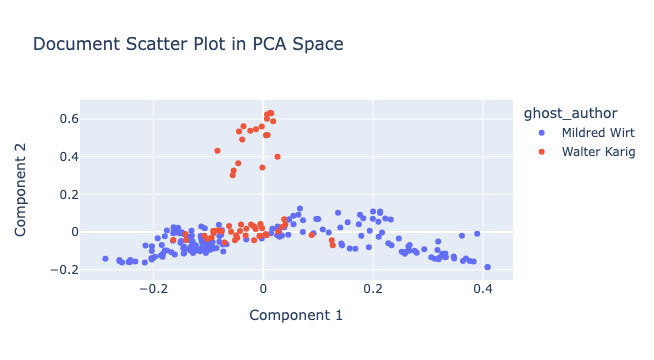

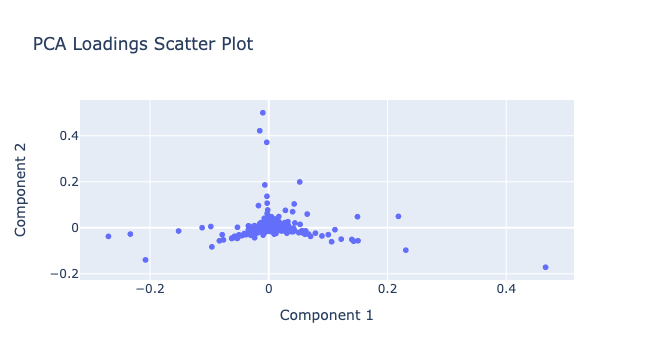

In [50]:
import plotly.express as px

# Visualization of documents in the space created by the first two PCA components
fig_docs = px.scatter(
    DOC.reset_index(), 
    x=0, 
    y=1, 
    color='ghost_author',
    labels={"0": "Component 1", "1": "Component 2"},
    title="Document Scatter Plot in PCA Space"
)
fig_docs.show()

# Visualization of loadings for the same two components
fig_loadings = px.scatter(
    x=LOADINGS.iloc[0],  # First component loadings
    y=LOADINGS.iloc[1],  # Second component loadings
    labels={'x': 'Component 1', 'y': 'Component 2'},
    title="PCA Loadings Scatter Plot"
)
fig_loadings.show()


## PCA Visualization 2 (4)

Include a scatterplot of documents in the space created by the second two components.

Color the points based on a metadata feature associated with the documents.

Also include a scatterplot of the loadings for the same two components. (This does not need a feature mapped onto color.)

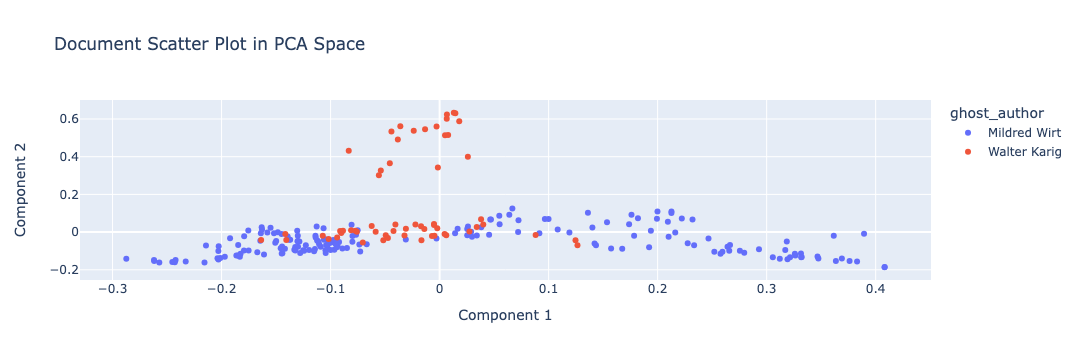

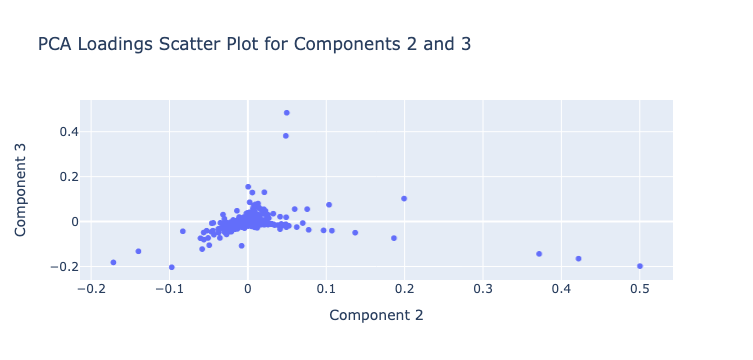


Briefly describe the nature of the polarity you see in the second component:

(INSERT DESCRIPTION HERE)

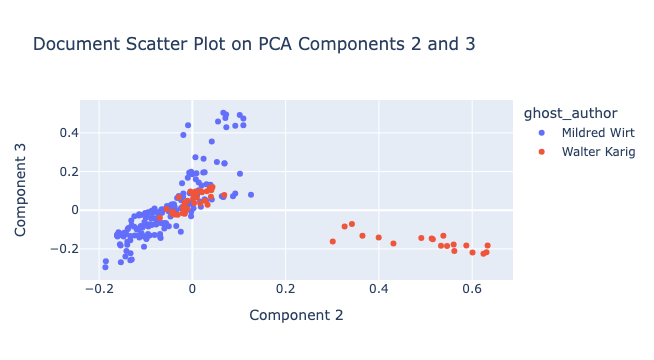

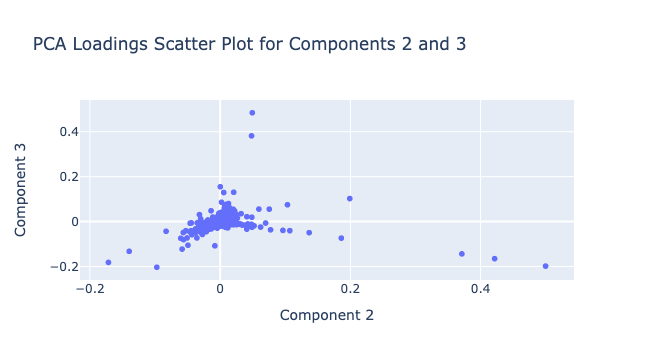

In [51]:
# Visualization of documents in the space created by the second and third PCA components
fig_docs = px.scatter(
    DOC.reset_index(), 
    x=1,  # Assuming the second PCA component is named '1'
    y=2,  # Assuming the third PCA component is named '2'
    color='ghost_author',  # Replace 'genre_id' with the actual metadata column name for coloring
    labels={"1": "Component 2", "2": "Component 3"},
    title="Document Scatter Plot on PCA Components 2 and 3"
)
fig_docs.show()

# Visualization of loadings for the second and third components
fig_loadings = px.scatter(
    x=LOADINGS.iloc[1],  # Second component loadings
    y=LOADINGS.iloc[2],  # Third component loadings
    labels={'x': 'Component 2', 'y': 'Component 3'},
    title="PCA Loadings Scatter Plot for Components 2 and 3"
)
fig_loadings.show()


## LDA TOPIC (4)

- UVA Box URL: https://virginia.box.com/s/shpyl5sie1cefby7cfg0qp84gvo5p2ty
- UVA Box URL of count matrix used to create: n/a
- GitHub URL for notebook used to create:
- Delimitter: ' '
- Libary used to compute: sklearn: CountVectorizer and LatentDirichletAllocation as LDA
- A description of any filtering, e.g. POS (Nouns and Verbs only): nouns and verbs only
- Number of components: 5
- Any other parameters used: max_features = 4000, max_iter = 10, stop_words = 'english'
- Top 5 words and best-guess labels for topic five topics by mean document weight:
  - T00: ['nancy' 'carol' 'mr' 'sidney' 'jemitt']
  - T01: ['nancy' 'said' 'mr' 'ghost' 'aunt']
  - T02: ['nancy' 'said' 'mr' 'bess' 'girls']
  - T03: ['gay' 'nancy' 'jean' 'gil' 'skin']
  - T04: ['alice' 'dave' 'ranch' 'shorty' 'horse']

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [61]:
# Filtered corpus by POS tags focusing on nouns and verbs
filtered_corpus = CORPUS[CORPUS['pos'].isin(['NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'])]

# Aggregate text by chapters
docs = filtered_corpus.groupby(['book_id', 'chap_num']).term_str.apply(lambda terms: ' '.join(terms))

# CountVectorizer configuration
n_components = 5
max_features = 4000
max_iter = 10

vectorizer = CountVectorizer(max_features=max_features, stop_words='english')
data_vectorized = vectorizer.fit_transform(docs)

In [62]:
# LDA Model
lda_model = LDA(n_components=n_components, max_iter=max_iter, learning_method='online', random_state=0)
lda_model.fit(data_vectorized)

# Extract the words most relevant to each topic
words = np.array(vectorizer.get_feature_names_out())
topic_summaries = []

# Access the components (topic-term distribution)
for i, topic_weights in enumerate(lda_model.components_):
    top_words = words[np.argsort(topic_weights)[:-6:-1]]
    topic_summaries.append(" ".join(top_words))
    print(f"T{i:02d}: {top_words}")

T00: ['nancy' 'carol' 'mr' 'sidney' 'jemitt']
T01: ['nancy' 'said' 'mr' 'ghost' 'aunt']
T02: ['nancy' 'said' 'mr' 'bess' 'girls']
T03: ['gay' 'nancy' 'jean' 'gil' 'skin']
T04: ['alice' 'dave' 'ranch' 'shorty' 'horse']


## LDA THETA (4)

- UVA Box URL: https://virginia.box.com/s/shpyl5sie1cefby7cfg0qp84gvo5p2ty
- GitHub URL for notebook used to create:
- Delimitter: ' '

In [63]:
lda_theta = lda_model.fit_transform(data_vectorized)
THETA = pd.DataFrame(lda_theta, 
                        index=pd.MultiIndex.from_tuples([(b, c) for b, c in docs.index], names=['book_id', 'chap_num']),
                        columns=[f'Topic {i}' for i in range(n_components)])

THETA

Topic 0   Topic 1   Topic 2   Topic 3   Topic 4
book_id chap_num                                                  
1       1         0.491487  0.000309  0.507585  0.000310  0.000310
        2         0.559618  0.000325  0.439405  0.000326  0.000325
        3         0.669861  0.000293  0.329259  0.000293  0.000294
        4         0.268747  0.000340  0.730230  0.000342  0.000341
        5         0.808195  0.000342  0.190773  0.000345  0.000345
...                    ...       ...       ...       ...       ...
12      16        0.000324  0.000321  0.998710  0.000322  0.000323
        17        0.000450  0.000448  0.998198  0.000449  0.000455
        18        0.000390  0.000388  0.998444  0.000388  0.000390
        19        0.000282  0.000280  0.998876  0.000280  0.000282
        20        0.000253  0.000250  0.998994  0.000251  0.000252

[237 rows x 5 columns]

## LDA PHI (4)

- UVA Box URL: https://virginia.box.com/s/shpyl5sie1cefby7cfg0qp84gvo5p2ty
- GitHub URL for notebook used to create:
- Delimitter: ' '

In [64]:
# Extract the feature names (words) from the vectorizer
terms = vectorizer.get_feature_names_out()

# Extract the topic-term matrix from the LDA model
topic_term_matrix = lda_model.components_

# Normalize the PHI matrix to probabilities
PHI = pd.DataFrame(topic_term_matrix, columns=terms, index=[f'Topic {i}' for i in range(n_components)])
PHI = PHI.div(PHI.sum(axis=1), axis=0)
PHI

abandoned    abbott  abducted  abductors    aboard      abom  \
Topic 0   0.000035  0.000048  0.000034   0.000031  0.000034  0.000119   
Topic 1   0.000178  0.000189  0.000190   0.000183  0.000190  0.000859   
Topic 2   0.000087  0.000181  0.000040   0.000058  0.000102  0.001297   
Topic 3   0.000127  0.000151  0.000126   0.000126  0.001439  0.000407   
Topic 4   0.000081  0.000079  0.000071   0.000075  0.000385  0.000101   

            aboms   abreast    abrupt   absence  ...      year     years  \
Topic 0  0.000049  0.000033  0.000054  0.000036  ...  0.000640  0.002038   
Topic 1  0.000293  0.000183  0.000174  0.000185  ...  0.000239  0.000311   
Topic 2  0.000290  0.000038  0.000043  0.000068  ...  0.000297  0.000683   
Topic 3  0.000161  0.000126  0.000131  0.000128  ...  0.000188  0.000400   
Topic 4  0.000084  0.000073  0.000072  0.000209  ...  0.000080  0.000119   

             yell    yelled    yellow       yep       yes  yesterday  \
Topic 0  0.000055  0.000189  0.000036  0.000033  0.000457   0.000055   
Topic 1  0.000208  0.000213  0.000180  0.000180  0.000284   0.000222   
Topic 2  0.000078  0.000111  0.000170  0.000041  0.000387   0.000219   
Topic 3  0.000143  0.000129  0.000141  0.000130  0.000179   0.000174   
Topic 4  0.000410  0.000109  0.000126  0.000070  0.000078   0.000078   

            youth    yvonne  
Topic 0  0.000034  0.000042  
Topic 1  0.000180  0.000183  
Topic 2  0.000074  0.000162  
Topic 3  0.000139  0.000156  
Topic 4  0.000075  0.000088  

[5 rows x 4000 columns]

## LDA + PCA Visualization (4)

Apply PCA to the PHI table and plot the topics in the space opened by the first two components.

Size the points based on the mean document weight of each topic (using the THETA table).

Color the points based on a metadata feature from the LIB table.

Provide a brief interpretation of what you see.

(INSERT IMAGE HERE)

(INSERT INTERPRETATION HERE)

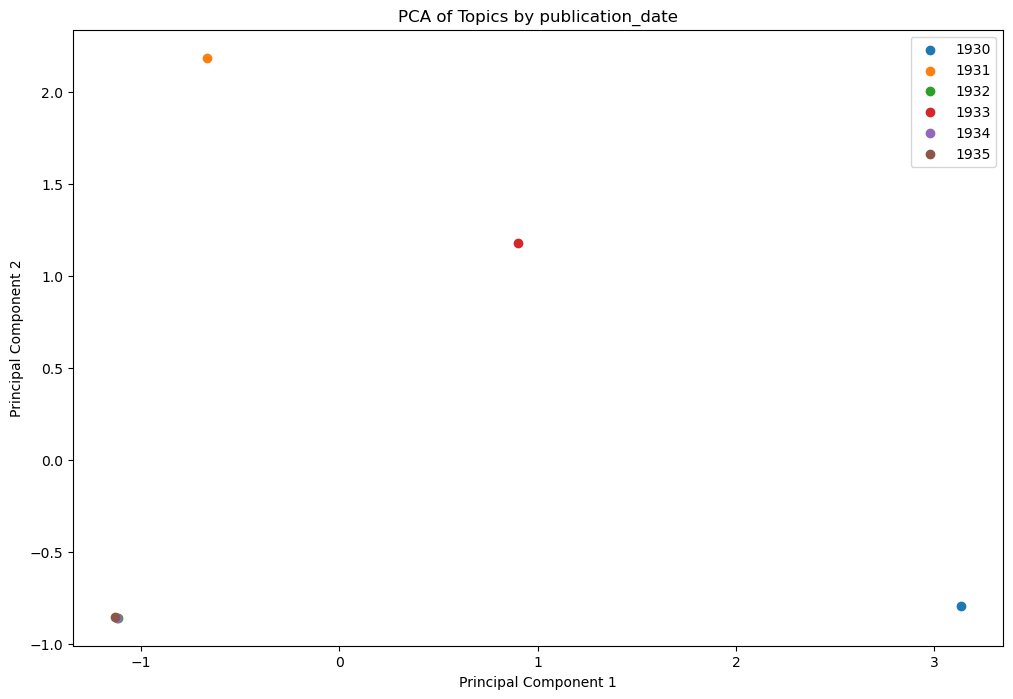

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


# Ensure LIB is indexed by book_id if it's not already
LIB = LIB.reset_index().set_index('book_id')

# Aggregate THETA to get mean topic distribution per book
mean_theta_per_book = THETA.groupby('book_id').mean()

# Join LIB to get ghost_author for each book_id
mean_theta_with_author = mean_theta_per_book.join(LIB['publication_date'])

# Aggregate to get mean topic distribution per ghost_author
mean_theta_per_author = mean_theta_with_author.groupby('publication_date').mean()

# Standardize data for PCA
scaler = StandardScaler()
theta_scaled = scaler.fit_transform(mean_theta_per_author)

# Perform PCA
pca = PCA(n_components=2)
author_pca = pca.fit_transform(theta_scaled)
author_pca_df = pd.DataFrame(author_pca, columns=['PC1', 'PC2'], index=mean_theta_per_author.index)

# Plotting
plt.figure(figsize=(12, 8))
for author in author_pca_df.index:
    plt.scatter(author_pca_df.loc[author, 'PC1'], author_pca_df.loc[author, 'PC2'],
                label=author)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Topics by publication_date')
plt.legend()
plt.show()


In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [67]:
# Reset the index of THETA if necessary to make 'book_id' the only index
if 'chap_num' in THETA.index.names:
    theta_with_metadata = THETA.reset_index(level='chap_num', drop=True)
else:
    theta_with_metadata = THETA.copy()

# Ensure that each 'book_id' in THETA is unique for the join
theta_with_metadata = theta_with_metadata[~theta_with_metadata.index.duplicated(keep='first')]

In [68]:
# Join THETA with LIB to get the ghost_author information
theta_with_metadata = theta_with_metadata.join(LIB['publication_date'])

# Group by ghost_author to get the mean topic distributions per author
grouped_theta = theta_with_metadata.groupby('publication_date').mean()

In [69]:
# Standardize the data for PCA
scaler = StandardScaler()
grouped_scaled = scaler.fit_transform(grouped_theta)

# Perform PCA
pca = PCA(n_components=2)
grouped_pca = pca.fit_transform(grouped_scaled)
grouped_pca_df = pd.DataFrame(grouped_pca, columns=['PC1', 'PC2'], index=grouped_theta.index)

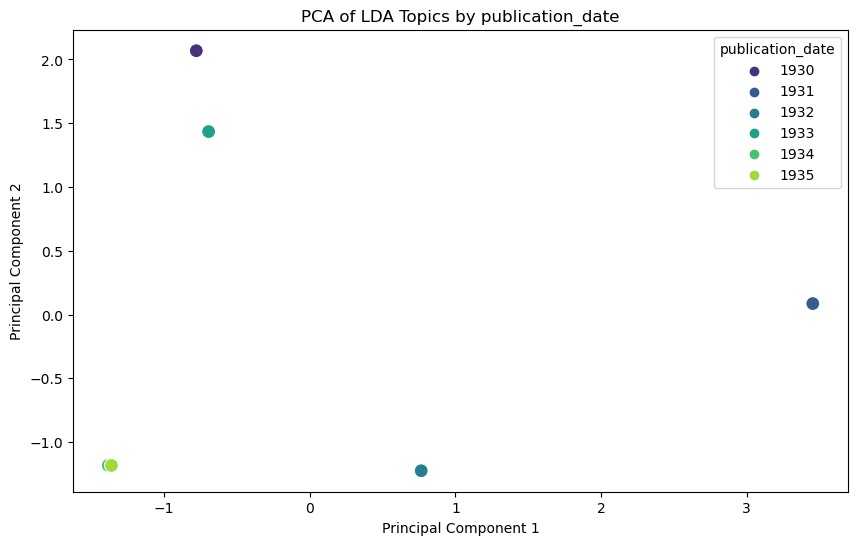

In [70]:
# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue=grouped_pca_df.index, data=grouped_pca_df, palette='viridis', s=100)
plt.title('PCA of LDA Topics by publication_date')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='publication_date')
plt.show()

In [71]:
# Step 1: Compute PCA on the PHI matrix
pca = PCA(n_components=2)  # We're only interested in the first two components
topic_space = pca.fit_transform(PHI)  # Transform the data to the new PCA space

In [72]:
# Step 2: Compute the mean document weight for each topic
mean_topic_weights = THETA.mean(axis=0).values

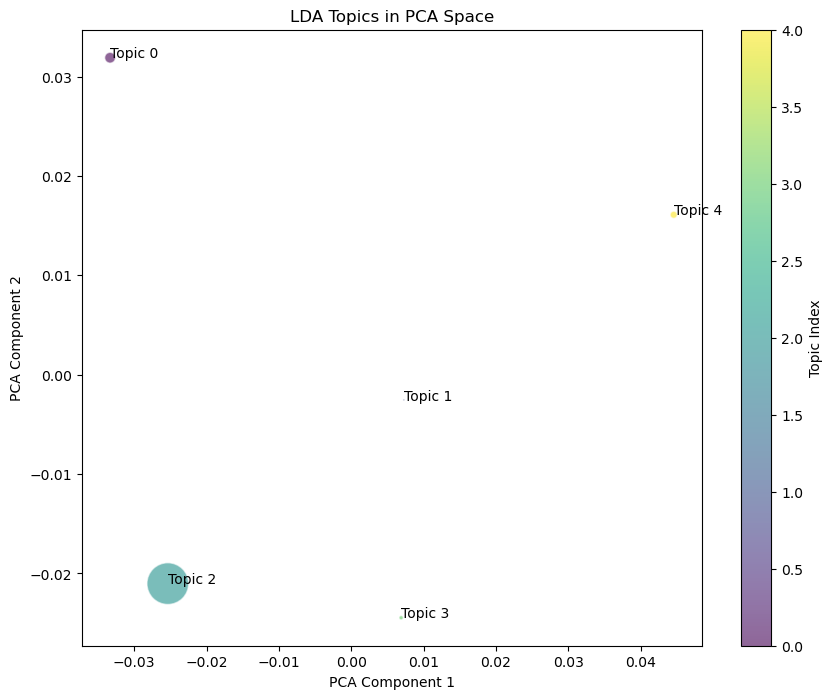

In [73]:
# Step 3: Prepare the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Each point represents a topic
scatter = ax.scatter(topic_space[:, 0], topic_space[:, 1], 
                     s=mean_topic_weights * 1000,  # Scale by mean document weight
                     c=np.arange(len(mean_topic_weights)),  # Color by topic index
                     cmap='viridis', alpha=0.6, edgecolors='w')

# Annotating points with topic numbers
for i, txt in enumerate(range(len(mean_topic_weights))):
    ax.annotate(f'Topic {txt}', (topic_space[i, 0], topic_space[i, 1]))

# Adding color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Topic Index')

# Adding labels and title
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_title('LDA Topics in PCA Space')

# Show the plot
plt.show()

## Sentiment VOCAB_SENT (4)

Sentiment values associated with a subset of the VOCAB from a curated sentiment lexicon.

- UVA Box URL: https://virginia.box.com/s/shpyl5sie1cefby7cfg0qp84gvo5p2ty
- UVA Box URL for source lexicon: 
- GitHub URL for notebook used to create:
- Delimitter: ' '

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from afinn import Afinn

In [108]:
# Initialize afinn sentiment analyzer
afinn = Afinn()

# Create a sample sentiment score column in VOCAB using Afinn (mock-up for demonstration)
# In practice, you would map actual sentiment scores to words found in both VOCAB and the Afinn lexicon
VOCAB_SENT = VOCAB.index.to_series().apply(afinn.score)

In [115]:
VOCAB_SENT.sample(10)

term_str
cordially    0.0
season       0.0
offers       0.0
swim         0.0
panicked    -3.0
inspired     2.0
heights      0.0
drowsy       0.0
expanded     0.0
put          0.0
Name: term_str, dtype: float64

## Sentiment BOW_SENT (4)

Sentiment values from VOCAB_SENT mapped onto BOW.

- UVA Box URL: https://virginia.box.com/s/shpyl5sie1cefby7cfg0qp84gvo5p2ty
- GitHub URL for notebook used to create:
- Delimitter: ' '

In [117]:
# Merge sentiment scores into the BOW DataFrame
BOW_SENT = BOW.reset_index().merge(
    VOCAB_SENT, 
    left_on='term_str', 
    right_index=True,
    how='left'
)

# Compute the sentiment for each term as the product of term frequency and sentiment score
BOW_SENT['term_sentiment'] = BOW_SENT['n'] * BOW_SENT['sentiment_score']

# Reset the index to match the BOW structure
BOW_SENT.set_index(['book_id', 'chap_num', 'term_str'], inplace=True)

KeyError: 'sentiment_score'

In [98]:
BOW_SENT

n     tfidf  sentiment_score  term_sentiment
book_id chap_num term_str                                               
1       1        able       4  0.008747              0.0             0.0
                 across     2  0.003853              0.0             0.0
                 ada        2  0.008881              0.0             0.0
                 address    1  0.002991              0.0             0.0
                 advancing  1  0.005723              0.0             0.0
...                        ..       ...              ...             ...
12      20       xx         1  0.003348              0.0             0.0
                 yard       1  0.002722              0.0             0.0
                 yes        1  0.001091              1.0             1.0
                 york       1  0.002788              0.0             0.0
                 young      6  0.006062              0.0             0.0

[124263 rows x 4 columns]

## Sentiment DOC_SENT (4)

Computed sentiment per bag computed from BOW_SENT.

- UVA Box URL: https://virginia.box.com/s/shpyl5sie1cefby7cfg0qp84gvo5p2ty
- GitHub URL for notebook used to create:
- Delimitter: ' '
- Document bag expressed in terms of OHCO levels: (book_id, chap_num)

In [101]:
# Compute the weighted sentiment score for each term in each document
BOW_SENT['weighted_sentiment'] = BOW_SENT['tfidf'] * BOW_SENT['sentiment_score']

# Aggregate these weighted sentiment scores at the document level
DOC_SENT = BOW_SENT.groupby(['book_id', 'chap_num']).apply(
    lambda df: np.sum(df['weighted_sentiment']) / np.sum(df['tfidf']) if np.sum(df['tfidf']) != 0 else 0
).reset_index(name='avg_sentiment')

DOC_SENT

book_id  chap_num  avg_sentiment
0          1         1       0.037083
1          1         2       0.035318
2          1         3      -0.015275
3          1         4       0.048903
4          1         5       0.156368
..       ...       ...            ...
232       12        16       0.004353
233       12        17      -0.045156
234       12        18      -0.043847
235       12        19      -0.038131
236       12        20       0.095151

[237 rows x 3 columns]

## Sentiment Plot (4)

Plot sentiment over some metric space, such as time.

If you don't have a metric metadata features, plot sentiment over a feature of your choice.

You may use a bar chart or a line graph.

(INSERT IMAGE HERE)

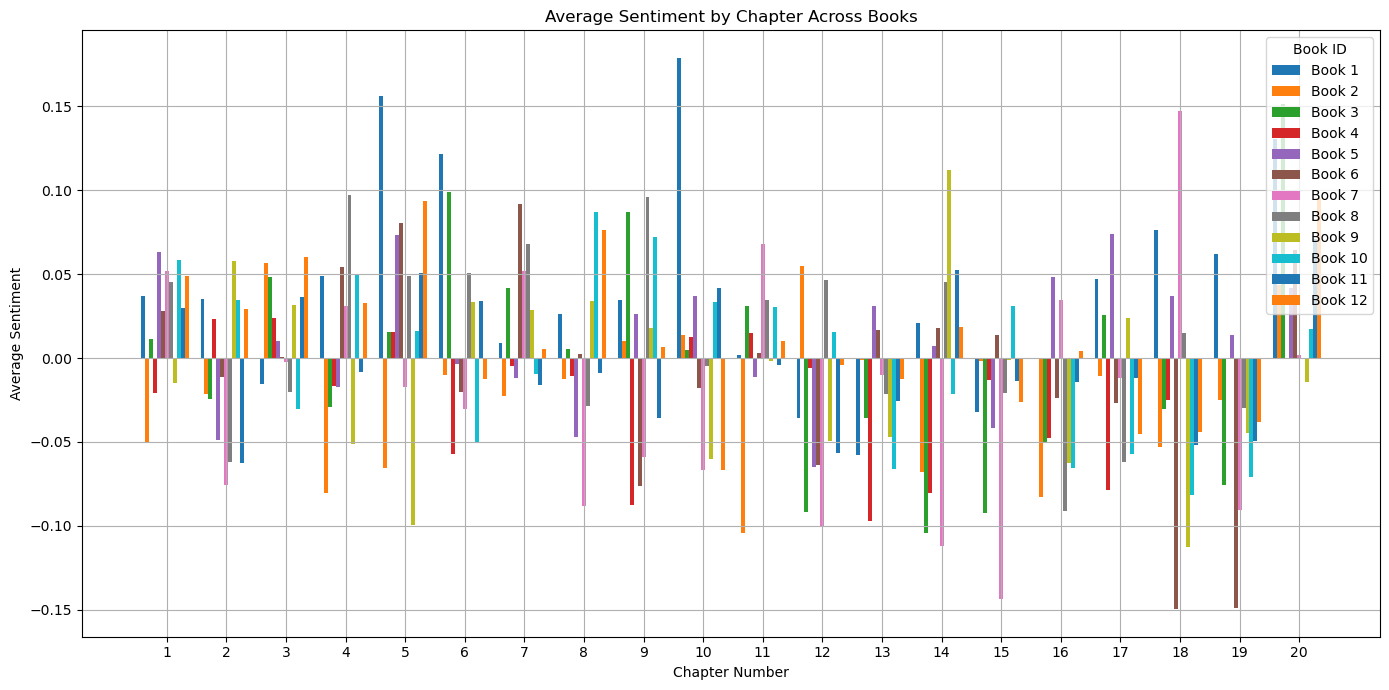

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming DOC_SENT is already structured with 'book_id', 'chap_num', and 'avg_sentiment'
plt.figure(figsize=(14, 7))

# To prevent bars from overlapping, calculate the number of unique chapters and create an offset for each book
num_books = DOC_SENT['book_id'].nunique()
width = 0.8 / num_books  # width of each bar, divided among books
book_ids = DOC_SENT['book_id'].unique()

for i, book in enumerate(sorted(book_ids)):
    # Subset data for each book
    subset = DOC_SENT[DOC_SENT['book_id'] == book]
    # Create an offset for each bar
    offsets = np.arange(len(subset['chap_num']))
    plt.bar(offsets + i * width, subset['avg_sentiment'], width=width, label=f'Book {book}')

plt.title('Average Sentiment by Chapter Across Books')
plt.xlabel('Chapter Number')
plt.ylabel('Average Sentiment')

# Set x-ticks to be in the middle of the grouped bars
plt.xticks(offsets + width * num_books / 2, subset['chap_num'])

plt.legend(title='Book ID')
plt.grid(True)
plt.tight_layout()
plt.show()


## VOCAB_W2V (4)

A table of word2vec features associated with terms in the VOCAB table.

- UVA Box URL: https://virginia.box.com/s/shpyl5sie1cefby7cfg0qp84gvo5p2ty
- GitHub URL for notebook used to create:
- Delimitter: ' '
- Document bag expressed in terms of OHCO levels:
- Number of features generated:
- The library used to generate the embeddings:

## Word2vec tSNE Plot (4)

Plot word embedding featues in two-dimensions using t-SNE.

Describe a cluster in the plot that captures your attention.

(INSERT IMAGE HERE)

(INSERT DESCRIPTION HERE)

# Riffs

Provde at least three visualizations that combine the preceding model data in interesting ways.

These should provide insight into how features in the LIB table are related. 

The nature of this relationship is left open to you -- it may be correlation, or mutual information, or something less well defined. 

In doing so, consider the following visualization types:

- Hierarchical cluster diagrams
- Heatmaps
- Scatter plots
- KDE plots
- Dispersion plots
- t-SNE plots
- etc.

## Riff 1 (5)

(INSERT IMAGE HERE)

(INSERT INTERPRETATION HERE)

## Riff 2 (5)

(INSERT IMAGE HERE)

(INSERT INTERPRETATION HERE)

## Riff 3 (5)

(INSERT IMAGE HERE)

(INSERT INTERPRETATION HERE)

# Interpretation (4)

Describe something interesting about your corpus that you discovered during the process of completing this assignment.

At a minumum, use 250 words, but you may use more. You may also add images if you'd like.

(INSERT INTERPRETATION HERE)